# Neurosymbolic Software Tutorial (Day 1)

## Instruction
- Navigating this notebook on Google Colab: There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executible code. Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing control/cmd + enter or by clicking the arrow on left-hand side as shown. `@TODO`
- Saving Work: If you wish to save your work in this .ipynb, we recommend downloading the compressed repository from GitHub, unzipping it, uploading it to Google Drive, opening this notebook from within Google Drive, and setting WITHIN_GDRIVE to True.



## Outline
```
# Part 1: Data Exploration
- Plot trajectories from `data/example` and explain what a program here should look like.
- End with a pseudo-dsl for this dataset.

# Part 2: DSL Generation
- Explain what a DSL is and how to specify it in this language.
- Show code for generating a DSL from the data.

# Part 3: Program Synthesis
- First, Explain enumeration. Next, show how to call BFS on the DSL and the data.
- Explain NEAR on a high level. Show how to call NEAR on the DSL and the data.

# Feedback
- A google form for comments/questions/concerns on the tutorial and on the framework design.
```

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
def datagen(B, T, is_regression=False):
    # generates a numpy trajectory of shape
    #   X = (B, T, d_inp)
    # and a numpy target of shape
    #   Y = (B, T, 1)
    # if regression task, y = distance from origin of X
    # if classification task, y = quadrant of X
    # X = np.random.randn(B, T, d_inp) # (B, T, d_inp) \in N(0, 1)
    X = np.random.rand(B, T, 2)

    X[:, 0, :] = 0
    for t in range(1, T):
        step = np.random.randn(B, 2) * 0.1
        X[:, t, :] = X[:, t-1, :] + step
    X = X.astype(np.float32)
    
    if is_regression:
        # y = distance from origin of X
        Y = np.zeros((B, T, 1))
        Y = np.linalg.norm(X, axis=2, keepdims=True)
        Y = Y.reshape(-1, T, 1)
        Y = Y.astype(np.float32)
    else:
        # y = quadrant of X
        Y = np.zeros((B, T), dtype=int)
        for i in range(B):
            for j in range(T):
                x, y = X[i, j, :]
                if x > 0 and y > 0:
                    Y[i, j] = 0
                elif x < 0 and y > 0:
                    Y[i, j] = 0
                elif x < 0 and y < 0:
                    Y[i, j] = 1
                else: # x > 0 and y < 0
                    Y[i, j] = 1
        Y = Y.reshape(B, T, 1)

    # normalize X b/w -1 and 1
    X = (X - np.min(X)) / (np.max(X) - np.min(X))
    X = (X - 0.5) * 2

    return X, Y

X_train, y_train = datagen(500, 10, is_regression=False)
X_test, y_test = datagen(50, 10, is_regression=False)
# save data
os.makedirs('../data/classification_example/', exist_ok=True)
np.save('../data/classification_example/train_ex_data.npy', X_train)
np.save('../data/classification_example/train_ex_labels.npy', y_train)
np.save('../data/classification_example/test_ex_data.npy', X_test)
np.save('../data/classification_example/test_ex_labels.npy', y_test)


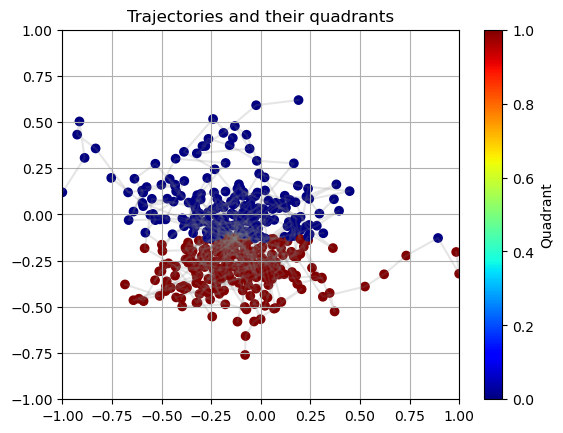

In [2]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize

def plot_trajectory(X, Y, is_regression=False):
    B, T, _ = X.shape
    
    if is_regression:
        cmap_name = 'gray_r'
        colorbar_label = "Distance from origin"
        title = "Trajectories and their distances from origin"
        norm = Normalize(vmin=Y.min(), vmax=Y.max())
    else:
        cmap_name = 'jet'
        colorbar_label = "Quadrant"
        title = "Trajectories and their quadrants"
        norm = Normalize(vmin=Y.min(), vmax=Y.max())
    
    for b in range(B):
        trajectory = X[b]
        output = Y[b].squeeze()

        plt.scatter(trajectory[:, 0], trajectory[:, 1], c=output, marker='o', cmap=cmap_name, norm=norm)
        
        plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.2, color='gray')
    
    plt.colorbar(label=colorbar_label)
    plt.title(title)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.grid(True)
    plt.show()

# Hope its clear that we are trying to predict the distance from origin
plot_trajectory(X_test, y_test)


Hopefully, it's clear that `y = l2_distance(origin, x)`. Assuming we want to discover this program, we need to first specify a DSL that contains this program.

It's going to look something like this:


In [3]:
import torch
import torch.nn as nn

from neurosym.dsl.dsl_factory import DSLFactory
from neurosym.examples.near.operations.basic import ite_torch
from neurosym.examples.near.operations.lists import fold_torch, map_torch

def simple_dsl(L, O):
    dslf = DSLFactory(L=L, O=O, max_overall_depth=5)
    dslf.typedef("fL", "{f, $L}")

    dslf.concrete("add", "() -> ($fL, $fL) -> $fL", lambda: lambda x, y: x + y)
    dslf.concrete("mul", "() -> ($fL, $fL) -> $fL", lambda: lambda x, y: x * y)
    dslf.concrete(
        "fold", "((#a, #a) -> #a) -> [#a] -> #a", lambda f: lambda x: fold_torch(f, x)
    )
    dslf.concrete(
        "sum", "() -> $fL -> f", lambda: lambda x: torch.sum(x, dim=-1).unsqueeze(-1)
    )
    dslf.parameterized(
        "linear", "() -> $fL -> $fL", lambda lin: lin, dict(lin=lambda: nn.Linear(L, L))
    )
    dslf.parameterized(
        "output",
        "(([$fL]) -> [$fL]) -> [$fL] -> [{f, $O}]",
        lambda f, lin: lambda x: lin(f(x)),
        dict(lin=lambda: nn.Linear(L, O)),
    )
    dslf.concrete(
        "ite",
        "(#a -> f, #a -> #a, #a -> #a) -> #a -> #a",
        lambda cond, fx, fy: ite_torch(cond, fx, fy),
    )
    dslf.concrete(
        "map", "(#a -> #b) -> [#a] -> [#b]", lambda f: lambda x: map_torch(f, x)
    )

    dslf.concrete(
        "compose", "(#a -> #b, #b -> #c) -> #a -> #c", lambda f, g: lambda x: g(f(x))
    )

    dslf.prune_to("[{f, $L}] -> [{f, $O}]")
    return dslf.finalize()

dsl = simple_dsl(X_test.shape[-1], y_test.shape[-1])


In [4]:
from neurosym.datasets.load_data import DatasetFromNpy, DatasetWrapper
dataset_factory = lambda train_seed: DatasetWrapper(
        DatasetFromNpy(
            "../data/classification_example/train_ex_data.npy",
            "../data/classification_example/train_ex_labels.npy",
            train_seed,
        ),
        DatasetFromNpy(
            "../data/classification_example/test_ex_data.npy",
            "../data/classification_example/test_ex_labels.npy",
            None,
        ),
        batch_size=200,
    )
datamodule = dataset_factory(42)
input_dim, output_dim = datamodule.train.get_io_dims()
print(input_dim, output_dim)

2 2


In [5]:
import neurosym as ns
from neurosym.examples import near

t = ns.TypeDefiner(L=input_dim, O=output_dim)
t.typedef("fL", "{f, $L}")
t.typedef("fO", "{f, $O}")
neural_dsl = near.NeuralDSL.from_dsl(
    dsl=dsl,
    modules={
        **near.create_modules(
            "mlp",
            [t("($fL) -> $fL"), t("($fL) -> $fO")],
            near.mlp_factory(hidden_size=10),
        ),
        **near.create_modules(
            "rnn_seq2seq",
            [t("([$fL]) -> [$fL]"), t("([$fL]) -> [$fO]")],
            near.rnn_factory_seq2seq(hidden_size=10),
        ),
    },
)


In [6]:
import pytorch_lightning as pl
import logging
logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)

trainer_cfg = near.NEARTrainerConfig(
    lr=1e-3,
    max_seq_len=100,
    n_epochs=10,
    num_labels=output_dim,
    train_steps=len(datamodule.train),
    loss_fn='NLLLoss',
)

def validation_cost(node):
    trainer = pl.Trainer(
        max_epochs=trainer_cfg.n_epochs,
        devices="auto",
        accelerator="cpu",
        enable_checkpointing=False,
        enable_model_summary=False,
        logger=False,
        callbacks=[],
    )
    try:
        initialized_p = neural_dsl.initialize(node.program)
    except near.PartialProgramNotFoundError:
        return 10000.

    model = neural_dsl.compute(initialized_p)
    if not isinstance(model, torch.nn.Module):
        del model
        del initialized_p
        model = near.TorchProgramModule(dsl=neural_dsl, program=node.program)
    pl_model = near.NEARTrainer(model, config=trainer_cfg)
    trainer.fit(
        pl_model, datamodule.train_dataloader(), datamodule.val_dataloader()
    )
    return trainer.callback_metrics["val_loss"].item()


In [7]:
def checker(node):
    """
    In NEAR, any program that has no holes is valid.
    The hole checking is done before this function will
    be called so we can assume that the program has no holes.
    """
    return (
        set(ns.symbols_for_program(node.program)) - set(dsl.symbols())
        == set()
    )

In [12]:
g = near.near_graph(
    neural_dsl,
    ns.parse_type(
        s="([{f, $L}]) -> [{f, $O}]", env=dict(L=input_dim, O=output_dim)
    ),
    is_goal=checker,
)

iterator = ns.search.bounded_astar(g, validation_cost, max_depth=3)
best_program_node = None
try:
    node = next(iterator)
    cost = validation_cost(node)
    best_program_node = (node, cost)
except StopIteration:
    pass


/Users/atharvas/miniconda3/envs/neurosym/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/atharvas/miniconda3/envs/neurosym/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


/Users/atharvas/miniconda3/envs/neurosym/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/atharvas/miniconda3/envs/neurosym/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 2/2 [00:00<00:00, 121.45it/s, train_loss=12.40, val_loss=12.90]


/Users/atharvas/miniconda3/envs/neurosym/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:43: UserWarning: attribute 'model' removed from hparams because it cannot be pickled
  rank_zero_warn(f"attribute '{k}' removed from hparams because it cannot be pickled")


Epoch 9: 100%|██████████| 2/2 [00:00<00:00, 115.68it/s, train_loss=3.270, val_loss=2.980]


In [14]:
best_program_node[0].program

SExpression(symbol='map', children=(SExpression(symbol='linear', children=()),))

Epoch 99: 100%|██████████| 2/2 [00:00<00:00, 147.89it/s, train_loss=4.570, val_loss=7.500]


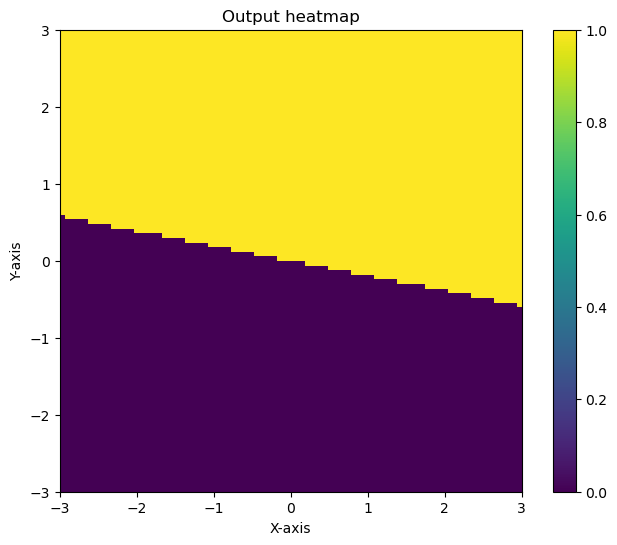

In [25]:
module = near.TorchProgramModule(dsl=neural_dsl, program=best_program_node[0].program)
lin = module.contained_modules[0]
# a satisfactory set of weights. @TODO: Remove
# lin.weight.data = torch.tensor([[0., 1.], [0., 0.]])
lin.bias.data = torch.tensor([0., 0.])

pl_model = near.NEARTrainer(module, config=trainer_cfg)
trainer = pl.Trainer(
    max_epochs=100,
    devices="auto",
    accelerator="cpu",
    enable_checkpointing=False,
    enable_model_summary=False,
    logger=False,
    callbacks=[],
)

trainer.fit(
    pl_model, datamodule.train_dataloader(), datamodule.val_dataloader()
)

grid = np.linspace(-3, 3, 100)
xx, yy = np.meshgrid(grid, grid)

X = np.stack([xx, yy], axis=-1)
X = X.reshape(-1, 2)
X = torch.tensor(X, dtype=torch.float32)
Y = lin(X)
Y = Y.detach().numpy()
Y = Y.reshape(100, 100, 2)
y = Y.argmax(axis=-1)
# Using imshow to plot y as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(y, origin='lower', extent=(-3, 3, -3, 3), cmap='viridis')  # Choose any colormap that suits your needs
plt.colorbar()
plt.title("Output heatmap")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()
